In [39]:
from gensim import corpora,models,similarities
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
sns.set(rc={'figure.figsize':(24, 12)})
from string import punctuation
import pymorphy2
from nltk.corpus import stopwords
import seaborn as sns
from tqdm.auto import tqdm, trange

In [2]:
morph = pymorphy2.MorphAnalyzer()

## Загрузка датасета и тестового набора и исследование данных

In [3]:
df = pd.read_csv("train_dataset_train.csv")
test = pd.read_csv("test_dataset_test+.csv")

In [4]:
df.describe(include=object)

,Текст Сообщения,Тематика,Ответственное лицо
count,2000,2000,2000
unique,1974,161,75
top,Свалка мусора,Нарушение дорожного покрытия (ямы) на дорогах...,Администрация города Курска
freq,8,155,421


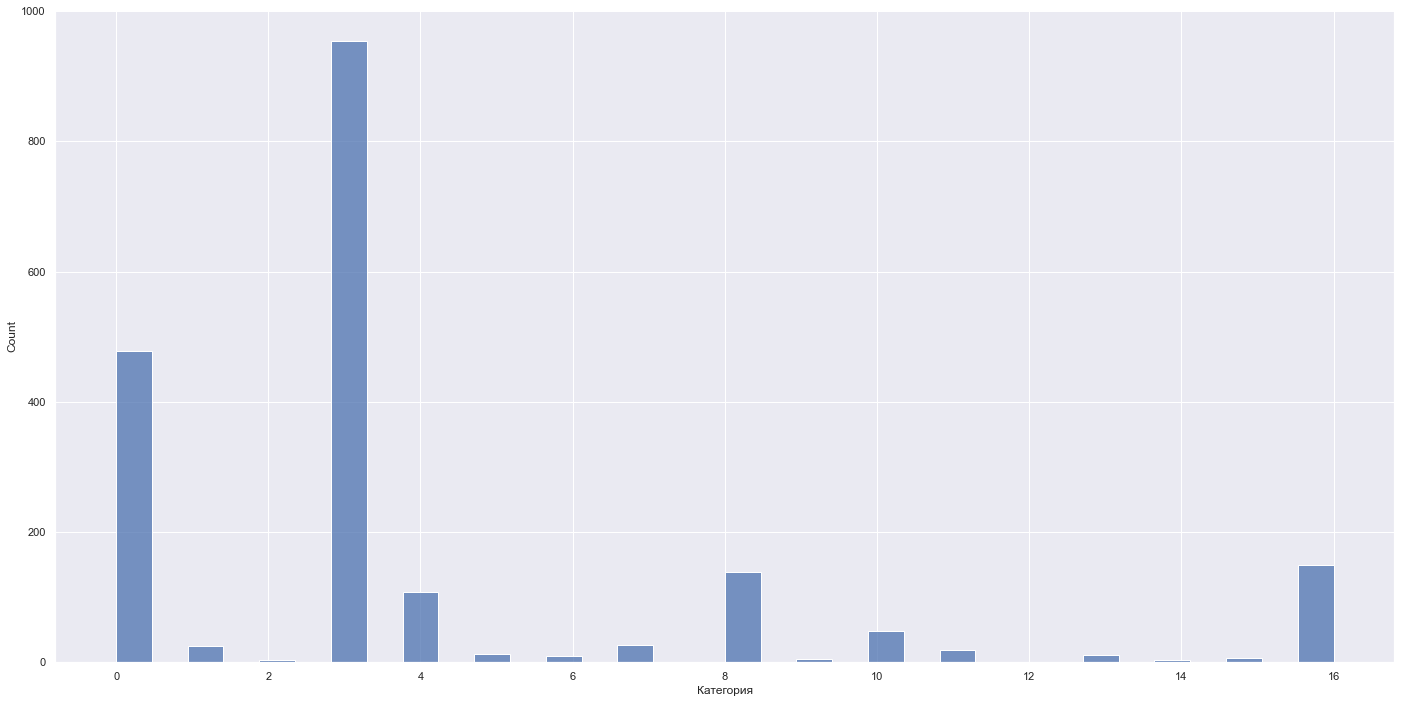

In [41]:
sns.histplot(x=df['Категория'])
plt.savefig('Cat')

In [7]:
labels = df['Категория'].unique()

In [8]:
# Создаем датасет, сливаем текстовые колонки, убираем ненужные колонки
data = df.drop(columns=['id', 'Тематика', 'Ответственное лицо']) # Удаление столбца с ID
test_d = test.drop(columns=['id', 'Тематика', 'Ответственное лицо']) # Удаление столбца с ID
data.head()

,Текст Сообщения,Категория
0,Помогите начальник Льговского рэс не реагирует...,3
1,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,3
2,Агресивные собаки. На радуге там стая из подро...,1
3,<p>На пересечении &nbsp;улиц Сосновская и Бере...,3
4,<p style=`text-align:justify;`><span style=`ba...,3


In [9]:
# Подсчет соотношения часла строк к число слов в строке
number_of_samples = len(data)
print("Количество строк (объектов)" , number_of_samples)

number_of_words = 0
for index, row in data.iterrows():
    words = row['Текст Сообщения'].split()
    number_of_words += len(words)
number_of_words_per_sample = number_of_words / len(data)
print("Количество cлов в строке" , number_of_words_per_sample)

ratio = number_of_samples / number_of_words_per_sample
print("Соотношение: " , ratio)

# Проводим выбор метода машинного обучения (модели) на основе вычисленного показателя

Количество строк (объектов) 2000
Количество cлов в строке 51.445
Соотношение:  38.8764700165225


## Обработка текста сообщения и удаление лишних символов

In [10]:
# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление латинских и прочих символов
def remove_symbols(my_string):
    l = "<>!&abcdefghijklmnoprstuvqwxyz-=/`:;!“”‚#$%&;()*+,-—./:;&lt;=>?@[\\]^_`{|}~\t\n\xa0"
    return "".join([ch for ch in my_string if ch not in l]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
    return re.sub(r'\s+', ' ', my_string, flags=re.I)

# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_symbols(remove_punctuation(text.lower()))))) 

# Создаем колонку в датасете для обработанного текста
data['text_processed'] = list(map(preproccessing, data['Текст Сообщения']))
test_d['text_processed'] = list(map(preproccessing, test_d['Текст Сообщения']))
test_d.head()

,Текст Сообщения,text_processed
0,<p>Здравствуйте. На улице Мира &nbsp;было заме...,здравствуйте на улице мира было заменено нару...
1,<p>Уже вторую неделю не горит уличное освещени...,уже вторую неделю не горит уличное освещение
2,Не работает освещение во дворе дома 11а по Эне...,не работает освещение во дворе дома а по энерг...
3,После покоса сорной растительности на газоне м...,после покоса сорной растительности на газоне м...
4,<p>Прошу принять меры к водителю маршрута 263:...,прошу принять меры к водителю маршрута пос се...


## Лемматизация

In [14]:
# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk

from nltk.stem.snowball import SnowballStemmer    # Стеммер Porter2 - новая версия стеммера Портера
from nltk.corpus import stopwords                 # Библиотека стоп-слов
from nltk import word_tokenize                    # Токенизатор

nltk.download('stopwords')                        # Загрузка стоп-слов
nltk.download('punkt')                            # Загрузка символов пунктуации
stemmer = SnowballStemmer("russian")  

[nltk_data] Error loading stopwords: <urlopen error [WinError 10061]
[nltk_data]     Подключение не установлено, т.к. конечный компьютер
[nltk_data]     отверг запрос на подключение>
[nltk_data] Error loading punkt: <urlopen error [WinError 10061]
[nltk_data]     Подключение не установлено, т.к. конечный компьютер
[nltk_data]     отверг запрос на подключение>


In [15]:
russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка
# Расширение списка стоп-слов (см. набор данных)
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan', 'аба', 'ан', 'ахз', 'аж', 'алит', 'авокруг', 'эт',
                         'этот', 'который', 'ым', 'которого', 'это', 'эп', 'эл', 'хх', 'добро', 'дол', 'др', 'зато', 'ибо',
                         'иначе', 'иной', 'итд', 'каков', 'какой', 'ка', 'хс', 'ещё', 'часто', 'мы', 'цо', 'пр'])

In [16]:
# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(data['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
data['text_lemmed'] = lemm_texts_column

data['text_lemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет именно деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать'

In [17]:
# Провердим лемматизацию и избавляемся от стоп-слов в  тестовом наборе
lemm_texts_column = []
for text in tqdm(test_d['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
test_d['text_lemmed'] = lemm_texts_column

test_d['text_lemmed'][0]

  0%|          | 0/1000 [00:00<?, ?it/s]

'здравствуйте улица мир заменить наружное освещение именно заменить лампа энергосберегающий лампа протяжение несколько месяц освещение улица отсутствовать последний улица осветить зима приблизительно каждый день человек работать часовой смена многие возвращаться очень поздно дать проблема улица посёлок'

## Мешок слов¶

In [18]:
# CountVectorizer - класс конвертации текста в матрицу токенов
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
# Создание матрицы признаков на основе мешка слов
count = CountVectorizer(ngram_range=(1, 1))
bag_of_words = count.fit_transform(data['text_lemmed'])
bag_of_words.toarray().shape

(2000, 8412)

## Взвешивание важности слов - TF-IDF

In [21]:
# TfidfVectorizer - класс для преобразования текста в частотные векторы слов
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# Создание матрицы признаков
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(data['text_lemmed'])
feature_matrix.toarray().shape

(2000, 8412)

## Уменьшение дисбаланса классов

In [26]:
#Увеличиваем минимальные классы путем копирования данных
d1 = data.loc[(data['Категория'] == 5) | (data['Категория'] == 15) | (data['Категория'] == 13) | (data['Категория'] == 6)]
d1 = pd.concat([d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,
               d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,
               d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1,d1], axis=0)


d2 = data.loc[(data['Категория'] == 12) | (data['Категория'] == 14) | (data['Категория'] == 2) | (data['Категория'] == 9)]
d2 = pd.concat([d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,
                d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,
               d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,
               d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,
               d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2], axis=0)

d3 = data.loc[(data['Категория'] == 1) | (data['Категория'] == 11) | (data['Категория'] == 7) | (data['Категория'] == 10)]
d3 = pd.concat([d3, d3, d3, d3, d3, d3,d3, d3, d3], axis=0)

dat = pd.concat([data, d1, d2, d3], axis=0)

In [27]:
#Перемешиваем массив
from sklearn.utils import shuffle
dat = shuffle(dat)

In [28]:
# Матрица признаков
X = dat['text_lemmed']

# Вектор значений целевых переменных
y = dat['Категория']

In [30]:
##Данные до сих пор имеют дисбаланс, поэтому дополнительно рассчитываем вес классов
from sklearn.utils.class_weight import compute_class_weight

weight = compute_class_weight(class_weight='balanced', classes=labels, y=y)
weight = {labels[i]:weight[i] for i in range(len(labels))}
weight

{3: 0.4987051424343322,
 1: 1.9030588235294117,
 16: 3.193051717331228,
 0: 0.9953236524735417,
 6: 0.6099547511312218,
 8: 3.4227676682183663,
 4: 4.405228758169935,
 13: 0.5545043192102016,
 10: 0.9911764705882353,
 11: 2.5040247678018575,
 14: 0.7929411764705883,
 7: 1.7620915032679738,
 5: 0.5082956259426847,
 15: 0.8713639301874596,
 2: 1.0572549019607844,
 9: 0.6343529411764706,
 12: 3.171764705882353}

In [31]:
# Разбиение на обучающую выборку (70%) и тестовую выборку (25%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Логистическая регрессия (Logistic Regression)

In [37]:
# Загрузка логистической регрессии, при исследовании моделей показала оптимальный результат
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=-1, C=1e4, fit_intercept=True, class_weight=weight,
                                          intercept_scaling=1,  max_iter=1000, multi_class='auto', penalty='l2',
                                          random_state=42, solver='newton-cg', tol=0.001)),
               ])

In [34]:
%%time
logreg.fit(X_train, y_train) # Обучение модели

Wall time: 15.8 s


Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=10000.0,
                                    class_weight={0: 0.9953236524735417,
                                                  1: 1.9030588235294117,
                                                  2: 1.0572549019607844,
                                                  3: 0.4987051424343322,
                                                  4: 4.405228758169935,
                                                  5: 0.5082956259426847,
                                                  6: 0.6099547511312218,
                                                  7: 1.7620915032679738,
                                                  8: 3.4227676682183663,
                                                  9: 0.6343529411764706,
                                                  10: 0.9911764705882353,
                                                  11: 2.5040247678018575,
                                                  12: 3.171764705882353,
                                                  13: 0.5545043192102016,
                                                  14: 0.7929411764705883,
                                                  15: 0.8713639301874596,
                                                  16: 3.193051717331228},
                                    max_iter=1000, n_jobs=-1, random_state=42,
                                    solver='newton-cg', tol=0.001))])

In [35]:
%%time
y_pred = logreg.predict(X_test)   # Предсказание на тестовых данных

Wall time: 190 ms


In [38]:
# Оценка точности классификации
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9713155291790306
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       118
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00       126
           3       0.90      0.87      0.88       223
           4       1.00      0.86      0.93        22
           5       1.00      1.00      1.00       230
           6       1.00      1.00      1.00       199
           7       0.99      1.00      0.99        76
           8       0.94      0.89      0.92        37
           9       1.00      1.00      1.00       199
          10       0.99      1.00      1.00       113
          11       1.00      1.00      1.00        53
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00       214
          14       1.00      1.00      1.00       146
          15       0.99      1.00      1.00       136
          16       0.93      0.74      0.82        34